## Overview
***
*A chatbot or chatterbot is a software application used to conduct an on-line chat conversation via text or text-to-speech, in lieu of providing direct contact with a live human agent chatbot is a type of software that can help human by automating conversations and interact with them through messaging platforms. here are different approaches and tools that you can use when building chatbots. Depending on the use case you want to address, some technologies are more appropriate than others. Combining artificial intelligence forms such as natural language processing, machine learning, and semantic understanding may be the best option to achieve the desired results.*
***


## How to build a Chatbot for our task?
***
ChatBots are usually Task specific means if there a chatbot which serves only food delivery app have trained on a dataset which
completely different from the dataset on which chatbot which serves online healthcare app. Similary, for this kaggle problem
we have provided with movie dataset which may feel that its not specific to any task, but actually it is specific to how people
will interect generally as these movie dialogues are nothing but daily life conversation between people however, that chatbot
may reply things which sounds too much dramatic and filmy like some dialogue of Tom cruise, shah rukh khan etc.

We can approch this problem by applying Neural network models like encoder-decoder architecture with some attention mechanism.
***

In [2]:
import numpy as np
import codecs
import tensorflow as tf
import pandas as pd
import ast
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
dialogs = pd.read_csv('../data/clean/nps_NATL_subset.csv')

In [4]:
print(dialogs.shape)
dialogs.head()

(23575, 13)


,Location,Workforce,NPS® Breakdown,respid2,NPS_Code,NPSCommentCleaned,NPSCommentLemmatised,NPSCommentPolarity,NPSCommentSubjectivity,OverallCommentCleaned,OverallCommentLemmatised,OverallCommentPolarity,OverallCommentSubjectivity
0,40,Precinct,Promoter,6985293,2,wonderful service and value,Wonderful service and value,1.000000,1.00,xyxyxz,xyxyxz,0.000000,0.000000
1,358,Precinct,Promoter,6750379,2,staff are professional and knowledgeable,Staff are professional and knowledgeable,0.100000,0.10,staff friendly and helpful,Staff friendly and helpful,0.375000,0.500000
2,1539,Precinct,Promoter,6876115,2,joey was very helpful,Joey was very helpful,0.200000,0.30,my first time there appointments ran very far ...,"My first time there, appointments ran very far...",0.004042,0.536037
3,145,Precinct,Promoter,6804405,2,excellent staff when item was returned for ser...,Excellent staff when item was returned for ser...,0.666667,0.75,xyxyxz,xyxyxz,0.000000,0.000000
4,444,Autotech,Promoter,6920693,2,everyone was very friendly and helpful,Everyone was very friendly and helpful.,0.487500,0.65,xyxyxz,xyxyxz,0.000000,0.000000


### We have given:-
1. ID: serial number
2. question: string representing questions
3. answer: string representing answers
4. question_as_int: tokenized question
5. answer_as_int: tokenized answer
6. question_len: no. of words in question
7. answer_len: no. of words in answer

##### Main concern is (question, answer) pair columns only, on which I'll train the model

In [44]:
data = dialogs[['NPSCommentCleaned']]
data['NPSCommentCleaned'] = data['NPSCommentCleaned'].astype(str)
data.head()

,NPSCommentCleaned
0,wonderful service and value
1,staff are professional and knowledgeable
2,joey was very helpful
3,excellent staff when item was returned for ser...
4,everyone was very friendly and helpful


##### Cheking if there is null or not

In [45]:
data.isnull().any()

NPSCommentCleaned    False
dtype: bool

##### Fetching all words which are like won't, aren't etc just to understand variety as we will convert all those to their proper forms

In [46]:
total_strings = data['NPSCommentCleaned'].values.tolist()
all_strings = " ".join(total_strings)
pattern = re.compile(r"[\w]*'[\w]*")
matchings = re.findall(pattern, all_strings)

In [47]:
set(matchings)

set()

## Preprocessing
Removing special characters and doing decontraction

In [48]:
from bby.util import remove_stopwords
def decontractions(phrase):
    #specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    text = text.lower()
    text = decontractions(text)
    # text = re.sub('[^A-Za-z0-9 ]+', '', text)
    words = remove_stopwords(text)
    text = " ".join(words)

    return text



In [57]:
from bby.util import nps_remove_stopwords
data['NPSCommentCleaned'] = data['NPSCommentCleaned'].apply(nps_remove_stopwords)
data.head()

,NPSCommentCleaned
0,wonderful value
1,staff professional knowledgeable
2,joey helpful
3,excellent staff item returned quick
4,everyone friendly helpful


In [58]:
q_lengths = data['NPSCommentCleaned'].str.split().apply(len)


In [59]:
from tqdm import tqdm 
all_ques = " ".join(data['NPSCommentCleaned'].values)
word_cnt_q = {}
for i in tqdm(all_ques.split()): word_cnt_q[i] = word_cnt_q.get(i, 0) + 1

100%|██████████| 256433/256433 [00:00<00:00, 1680932.27it/s]


In [60]:

word_ordered_q = sorted(word_cnt_q, key=lambda x: word_cnt_q[x], reverse=True)
top_20_q = word_ordered_q[:20]
cnts_20_q = [word_cnt_q[i] for i in top_20_q]


In [61]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
def plot(top_words, counts):    
    fig, ax = plt.subplots()

    # Save the chart so we can loop through the bars below.
    bars = ax.bar(
        x=np.arange(len(top_words)),
        height=counts,
        tick_label=top_words
    )

    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    # Add text annotations to the top of the bars.
    bar_color = bars[0].get_facecolor()
    for bar in bars:
      ax.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 0.3,
          round(bar.get_height(), 1),
          horizontalalignment='center',
          color=bar_color,
          weight='bold'
      )

    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    ax.set_xlabel('Word', labelpad=15, color='#333333')
    ax.set_ylabel('Count', labelpad=15, color='#333333')
    ax.set_title("Most usual words in reply/answers", pad=15, color='#333333',
                 weight='bold')

    fig.tight_layout()

## Let's have a look on the distribution of words in the dataset

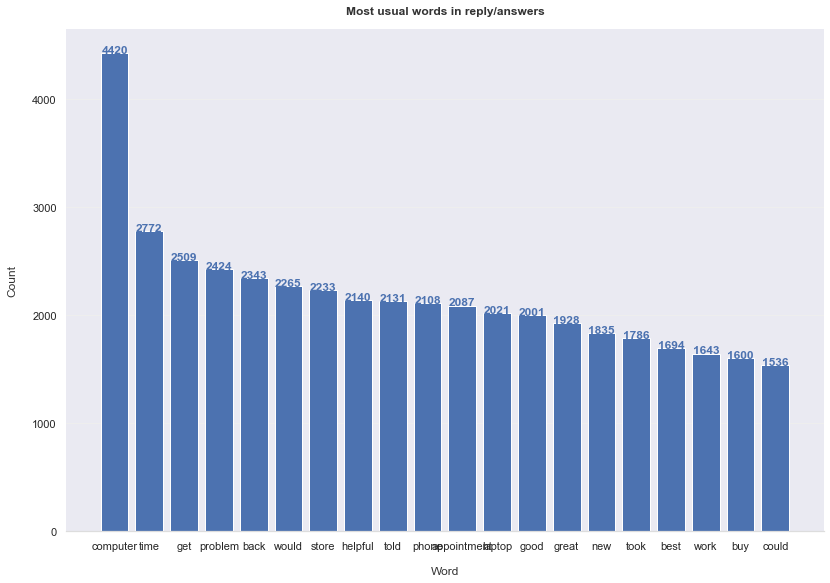

In [62]:

plot(top_20_q, cnts_20_q) 

In [63]:

word_ordered_q = sorted(word_cnt_q, key=lambda x: word_cnt_q[x], reverse=True)
top_20_q = []
for i in word_ordered_q:
    if len(top_20_q) == 20: break
    if len(i) >= 5:
        top_20_q.append(i)
cnts_20_q = [word_cnt_q[i] for i in top_20_q]


#### Most used words having length > 5, questions

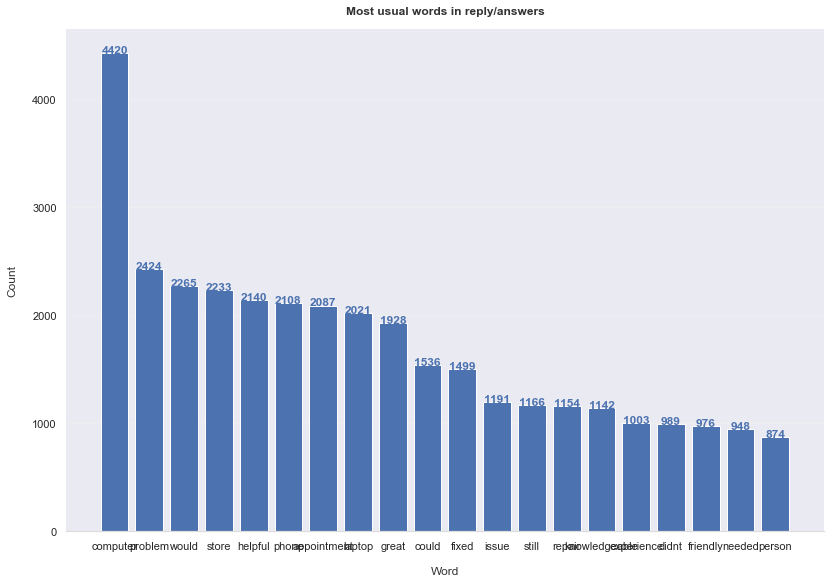

In [64]:

plot(top_20_q, cnts_20_q) 

#### Sentence lengths are more likely to occure in range (2-7)

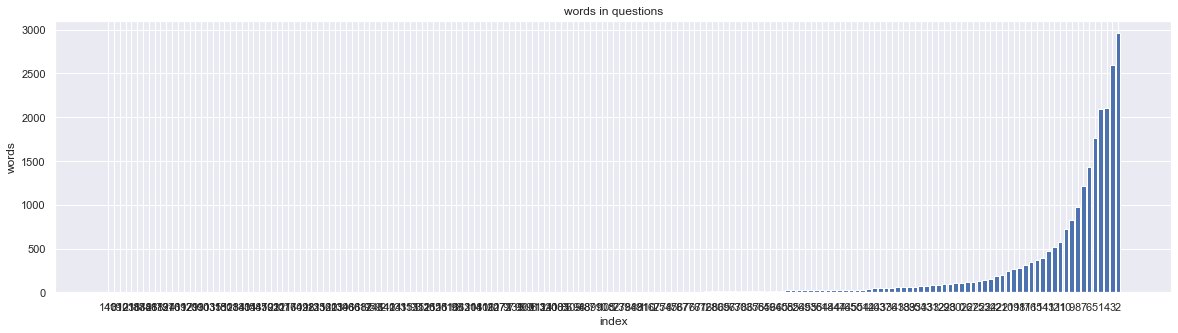

In [65]:
answer_count = data['NPSCommentCleaned'].str.split().apply(len).value_counts()
word_dict = dict(answer_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('words')
plt.xlabel('index')
plt.title('words in questions')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

#### Sentence lengths are more likely to occure in range (2-7)

##### Minimum no. of words required to explain maximum no. of document in the corpus for answer set

In [66]:
for i in range(0,101,10):
    print(i,np.percentile(q_lengths, i))
print("="*80)
for i in range(90,101):
    print(i,np.percentile(q_lengths, i))
print("="*80)
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(q_lengths, i))

0 0.0
10 2.0
20 2.0
30 3.0
40 4.0
50 6.0
60 7.0
70 10.0
80 15.0
90 24.0
100 434.0
90 24.0
91 26.0
92 28.0
93 31.0
94 34.0
95 38.0
96 42.0
97 50.0
98 61.0
99 82.0
100 434.0
99.1 84.0
99.2 88.0
99.3 91.0
99.4 99.0
99.5 107.13000000000102
99.6 113.0
99.7 124.27799999999843
99.8 148.85199999999895
99.9 178.4260000000031
100 434.0


##### Minimum no. of words required to explain maximum no. of document in the corpus for question set

## I'm going to try Simple encoder decoder for training at first, For that I need to Do some preprocessing!

#### Adding \<start>, \<end> tokens, for to apply one time-shifted technique!

In [ ]:
data['answer_in'] = '<start> ' + data['answer'].astype(str)
data['answer_out'] = data['answer'].astype(str) + ' <end>'
data.head()

In [ ]:
data_final = data.drop(['answer'], axis=1)
data_final.head()

### Train test split of the dataset

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data_final, test_size=0.2)

### Adding  \<end> in Answer_in so that it can be tokenized by tokenizer!

In [ ]:
train.iloc[0]['answer_in']= str(train.iloc[0]['answer_in'])+' <end>'
train.iloc[0]['answer_out']= str(train.iloc[0]['answer_out'])+' <end>'

### Saving data set for to use in training!, in the next notebook.

In [ ]:
 import joblib
# joblib.dump(data, "train")
# joblib.dump(validation, "validation")
# train = joblib.load("train")
# validation = joblib.load("validation")

In [ ]:

# i, cnt = 0, 0
# a = [5, 19, 1, 8]
# a.sort(reverse=True)
# s = sum(a)
# h = s/2
# while(i != len(a)-1):
#     while(a[i] >= a[i+1] and s > h):
#         s = s - a[i]
#         a[i] = a[i]/2
#         s = s + a[i]
#         cnt += 1          
#     i += 1
#     if s <= h: break
        
#     if i == len(a)-1:
#         cnt += 1
#         break 

In [ ]:
cnt